## CX4240 project

# Classification of Acute Lymphoblastic Leukemia (ALL) in Blood Cell Images Using Machine Learning





In [65]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.stats as stat
import sklearn.preprocessing as pre
import glob
import mahotas as mt
import pywt
import seaborn as sns
import pandas as pd

from skimage.feature import local_binary_pattern
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn import svm
%matplotlib inline


# Load Images

In [2]:
def find_path(stage, fold=None, label=None):
    """
    ARGS:    stage: 'train' or 'test'
             fold: int
             label: 'all' or 'hem'
    returns: general file path for given inputs
    """
    og_path = '/Users/1000j/CX4240+/Cell_Images/'
    if stage == 'train':
        return og_path + 'C-NMC_training_data/fold_' + str(fold) + '/' + label + '/*.bmp'
    elif stage == 'test':
        return og_path + 'C-NMC_test_prelim_phase_data/'*2 + '*.bmp'
    else:
        print('must enter "train" or "test"')
        return

def read_images(stage, fold=None, label=None):
    """
    ARGS:    stage: 'train' or 'test'
             fold: int
             label: 'all' or 'hem'
    returns: color: list of all color images
             gray: list of all gray images
             ids: list of associated image ids
    """
    
    img_path = find_path(stage, fold, label)
    start = len(img_path) - 5
#    color, gray, ids = [], [], []
    
    ids = []
    for name in glob.glob(img_path):
        ids.append(name[start : -4])
#        color.append(cv2.imread(name))
#        gray.append(cv2.imread(name, 0))
    color = np.array([cv2.imread(file) for file in glob.glob(img_path)])
    gray = np.array([cv2.imread(file,0) for file in glob.glob(img_path)])
    ret, binary = cv2.threshold(gray,20,255,cv2.THRESH_BINARY)

    print('done loading images')
    return color, gray, binary, ids

In [3]:
ALL_0_color, ALL_0_gray, ALL_0_binary, ids_0_ALL = read_images('train', 0, 'all')
hem_0_color, hem_0_gray, hem_0_binary, ids_0_hem = read_images('train', 0, 'hem')

done loading images
done loading images


(<matplotlib.axes._subplots.AxesSubplot at 0x1e154917400>,
 Text(0.5, 1.0, 'Normal binary'))

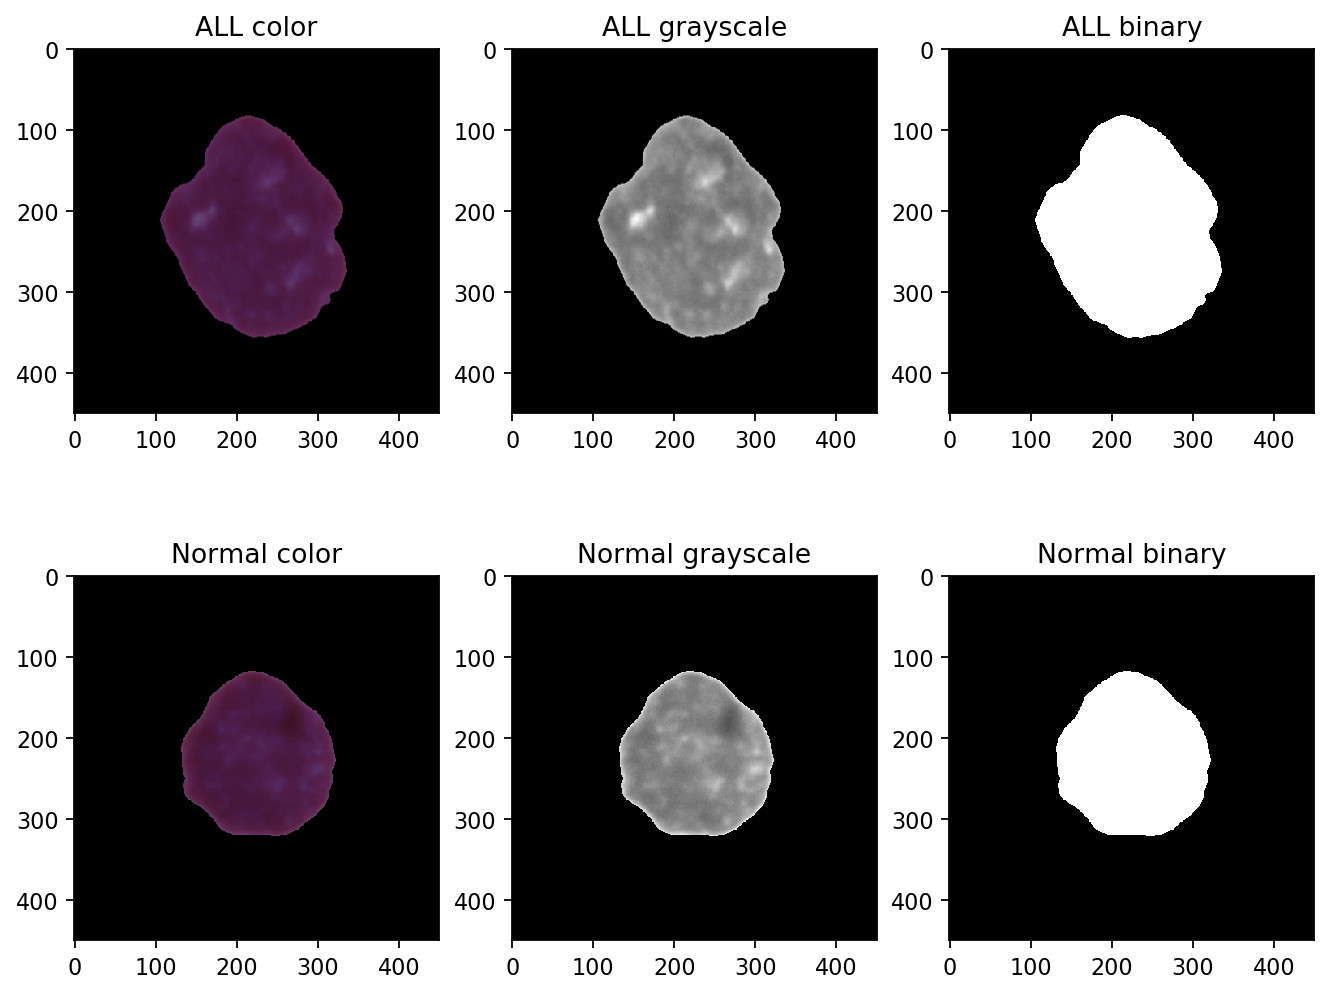

In [4]:
plt.figure(num=None, figsize=(10, 8), dpi=160, facecolor='w', edgecolor='k')
plt.subplot(2,3,1), plt.imshow(ALL_0_color[1270]), plt.title('ALL color')
plt.subplot(2,3,2), plt.imshow(ALL_0_gray[1270],'gray'), plt.title('ALL grayscale')
plt.subplot(2,3,3), plt.imshow(ALL_0_binary[1270],'gray'), plt.title('ALL binary')
plt.subplot(2,3,4), plt.imshow(hem_0_color[127]), plt.title('Normal color')
plt.subplot(2,3,5), plt.imshow(hem_0_gray[127],'gray'), plt.title('Normal grayscale')
plt.subplot(2,3,6), plt.imshow(hem_0_binary[127],'gray'), plt.title('Normal binary')

# Feature extraction
    F1: cell size
    F2: perimeter
    F3: form factor
    F4: roundness
    F5: length/diameter ratio
    F6: compactness
    F7-F9: contour signature of nucleus: 
        variance, skewness, and kurtosis of the distances between centroid and contour points
    F10-F22: Haralick texture 
        angular second moment
        contrast
        correlation
        variance
        inverse difference moment
        sum average
        sum variance
        sum entropy
        difference entropy
        information measures of correlation (F12, F13)
    F23-30: Haar wavelet texture
        Means and variances of low-pass filtered appriximation image 
        and high-pass filterd in horizontal, vertical, and diagonal directions
    F31-F36: color features
        Means in RGB
        Means in HSV



In [71]:
features = ['Cell Size','Perimeter','Form Factor','Roundness','Length/Diameter Ratio','Compactness',
            'Boundary Roughness Variance','Boundary Roughness Skewness','Boundary Roughness Kurtosis',
            'Haralick Angular Second Moment','Haralick Contrast','Haralick Correlation','Haralick Variance',
            'Haralick Inverse Difference Moment','Haralick Sum Average','Haralick Sum Variance',
            'Haralick Sum Entropy','Haralick Entropy','Haralick Difference Variance','Haralick Difference Entropy',
            'Haralick Information Measures of Correlation 1','Haralick Information Measures of Correlation 2',
            'Wavelet Approximation Mean','Wavelet Horizontal Mean','Wavelet Vertical Mean','Wavelet Diagonal Mean',
            'Wavelet Approximation Variance', 'Wavelet Horizontal Variance','Wavelet Vertical Variance',
            'Wavelet Diagonal Variance','Red Mean','Green Mean','Blue Mean','Hue Mean','Saturation Mean','Value Mean']

## Morphological feature extraction

In [6]:
# Morphological features
def get_cell_size(image):
    """
    ARGS:    
        image: black and white image
    returns:
        size: the number of pixels in the cell
    """
#    ret,thresh=cv2.threshold(image,THRESH,255,cv2.THRESH_BINARY)
#    return cv2.countNonZero(image)
    return np.count_nonzero(image, axis=(1,2))

def get_cell_perimeter(image):
    """
    ARGS:    
        image: black and white image
    returns:
        perimeter: the number of pixels in the perimeter
        cnt: x,y coordiantes of boundary (list)
    """
#    ret,thresh = cv2.threshold(image,THRESH,255,cv2.THRESH_BINARY)
    perimeter = np.zeros(len(image))
    cnt = []
    for i in range(len(image)):
        _, contour, _ = cv2.findContours(image[i], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        perimeter[i] = contour[0].shape[0]
        cnt.append(contour[0])
    return perimeter, cnt

def get_centeroid(image):
    """
    arg:
        image: binary image
    returns:
        cx: x coordinate of center
        cy: y coordinate of center
    """
    cx = np.zeros(len(image), dtype=int)
    cy = np.zeros(len(image), dtype=int)
    for i in range(len(image)):
        M = cv2.moments(image[i])
        cx[i] = int(M['m10']/M['m00'])
        cy[i] = int(M['m01']/M['m00'])
    return cx,cy
    
def get_diameter(image):
    """
    args:
        image: binary images
    returns: 
        major_d: the maximum diameter (number of pixels) on the major axis
        minor_d: the diameter (number of pixels) on the minor axis (perpendicular to the major axis)
        min_d: the minimum diameter 
    """
    (rows, cols) = image[0].shape[:2] 
    major_d = np.zeros(len(image))
    minor_d = np.zeros(len(image))
    min_d = rows*np.ones(len(image))
    major_img = np.zeros(np.shape(image))
    minor_img = np.zeros(np.shape(image))
    for i in range(len(image)):
        for ang in range(0,180,10):
            # Images are rotated 0 to 170 degrees with the increment of 10 degrees
            # getRotationMatrix2D creates a matrix needed for transformation. 
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), ang, 1) 
            rotated_img = cv2.warpAffine(image[i], M, (cols, rows))
            temp_d = np.count_nonzero(rotated_img[int(rows/2),:]) # count pixels
            if temp_d > major_d[i]:
                major_d[i] = temp_d
                minor_d[i] = np.count_nonzero(rotated_img[:,int(cols/2)]) 
            if temp_d < min_d[i]:
                min_d[i] = temp_d
    return major_d, minor_d, min_d

In [9]:
#F1 size
F1_all = get_cell_size(ALL_0_binary)
F1_hem = get_cell_size(hem_0_binary)
#F2 perimeter
F2_all, ALL_0_cnt = get_cell_perimeter(ALL_0_binary)
F2_hem, hem_0_cnt= get_cell_perimeter(hem_0_binary)

ALL_0_major_d, ALL_0_minor_d, ALL_0_min_d = get_diameter(ALL_0_binary)
hem_0_major_d, hem_0_minor_d, hem_0_min_d= get_diameter(hem_0_binary)
ALL_0_cx, ALL_0_cy = get_centeroid(ALL_0_binary)
hem_0_cx, hem_0_cy = get_centeroid(hem_0_binary)

In [10]:
def get_form_factor(area, perimeter):
    """
    args: 
        area: the area of cell (cell size)
        perimeter: the total number of pixels representing the cell boundary
    returns: 
        form_factor: shape of cell
    """
    return 4*np.pi*area/perimeter**2

def get_roundness(area, major_diameter):
    """
    args: 
        area: the area of cell (cell size)
        major_diameter: the diameter of cell on the major axis
    returns: 
        roundness: the degree to which the cell shape differs from that of a circle
    """
    return 4*area/(np.pi*major_diameter**2)

def get_diameter_ratio(major_d, minor_d):
    """
    args:
        major_d: the maximum diameter (number of pixels) on the major axis
        minor_d: the diameter (number of pixels) on the minor axis (perpendicular to the major axis
    returns: 
        ratio: ratio of major_d and minor_d
    """
    return major_d/minor_d

def get_compactness(area, major_diameter):
    """
    args: 
        area: area of cell (cell size)
        major_diameter: the diameter of cell on the major axis
    returns: 
        compactness: the degree to how compact the shape of cell is
    """
    return ((4*area/np.pi)**(-1/2))/major_diameter

def get_contour_signature(image, cnt, cx, cy):
    """ Boundary roughness
    arg:
        image: binary images
        cnt: (list of numpy array ixjxk) x,y coordiantes of boundary
        cx: x coordinate of center
        cy: y coordinage of center
    returns:
        variance, skewness, kurtosis
    """
    variance = np.zeros(len(image))
    skewness = np.zeros(len(image))
    kurtosis = np.zeros(len(image))
    for i in range(len(image)):
        xy = cnt[i]
        norm2 = np.zeros(len(xy))
        for j in range(len(xy)):
            norm2[j] = np.linalg.norm((cx[i],cy[i])-xy[j,0,:])
        variance[i] = np.var(norm2)
        skewness[i] = stat.skew(norm2)
        kurtosis[i] = stat.kurtosis(norm2)
    return variance, skewness, kurtosis
        

In [11]:
#F3 form factor
F3_all = get_form_factor(F1_all, F2_all)
F3_hem = get_form_factor(F1_hem, F2_hem)
#F4 roundness
F4_all = get_roundness(F1_all, ALL_0_major_d)
F4_hem = get_roundness(F1_hem, hem_0_major_d)
#F5 diameter ratio
F5_all = get_diameter_ratio(ALL_0_major_d, ALL_0_minor_d)
F5_hem = get_diameter_ratio(hem_0_major_d, hem_0_minor_d)
#F6 compactness
F6_all = get_compactness(F1_all, ALL_0_major_d)
F6_hem = get_compactness(F1_hem, hem_0_major_d)
#F7-F9 variance, skewness, kurtosis (boundary roughness)
F7_all, F8_all, F9_all = get_contour_signature(ALL_0_binary, ALL_0_cnt, ALL_0_cx, ALL_0_cy)
F7_hem, F8_hem, F9_hem = get_contour_signature(hem_0_binary, hem_0_cnt, hem_0_cx, hem_0_cy)

## Texture features extraction

In [12]:
# Texture features
def crop_image(image, cx, cy, min_d=50):
    """
        args:
            image: grayscale image
            cx: x coordinate of center (row)
            cy: y coordiante of center (column)
            mid_d: (int) minimum diameter of all cells
        returns:
            new_img: cropped images with size min_d by min_d
    """
    rows, cols = image[0].shape[:2] 
    l = np.int(np.min(min_d)/2)
    for i in range(len(image)):
        new_img = image[:,cx[i]-l:cx[i]+l,cy[i]-l:cy[i]+l]
    return new_img

def Haralick(img):
    '''Haralick texture using Gray-level co-occurrence matrix (GLCM)
    arg: 
        img: N number of MxM grayscale images
    return: 
        Haralick_texture: Nx13 array with 13 features 
    '''
    Haralick_texture = []
    for i in range(len(img)):
        feat = mt.features.haralick(img[i,:,:], return_mean=True)
        Haralick_texture.append(feat)
    Haralick_texture = np.array(Haralick_texture)     
    return Haralick_texture
    
def Haar_wavelet(img):
    '''Extract Haar wavelet texture features
    Means and variances of low-pass filtered appriximation image 
    and high-pass filterd in horizontal, vertical, and diagonal directions
    arg:
        img: N number of MxM grayscale images
    return: 
        Haar_wavelet_features: Nx8 array with 8 features
            (cA_mean, cH_mean, cV_mean, cD_mean, cA_var, cH_var, cV_var, and cD_var)
    '''
    cA, (cH, cV, cD) = pywt.dwt2(img,'haar')
    n = len(cA)
    cA_mean = np.reshape(cA.mean(axis=(1,2)), (n,1))
    cH_mean = np.reshape(cH.mean(axis=(1,2)), (n,1))
    cV_mean = np.reshape(cV.mean(axis=(1,2)), (n,1))
    cD_mean = np.reshape(cD.mean(axis=(1,2)), (n,1))
    cA_var = np.reshape(cA.var(axis=(1,2)), (n,1))
    cH_var = np.reshape(cH.var(axis=(1,2)), (n,1))
    cV_var = np.reshape(cV.var(axis=(1,2)), (n,1))
    cD_var = np.reshape(cD.var(axis=(1,2)), (n,1))
    
    Haar_wavelet_features = np.hstack((cA_mean,cH_mean,cV_mean,cD_mean,cA_var,cH_var,cV_var,cD_var))
    return Haar_wavelet_features

In [13]:
#new images for texture feature extraction
ALL_0_texture = crop_image(ALL_0_gray, ALL_0_cx, ALL_0_cy)
hem_0_texture = crop_image(hem_0_gray, hem_0_cx, hem_0_cy)

#F10-F22
Haralick_all = Haralick(ALL_0_texture)
Haralick_hem = Haralick(hem_0_texture)
#F23-30
Haar_wavelet_all = Haar_wavelet(ALL_0_texture)
Haar_wavelet_hem = Haar_wavelet(hem_0_texture)    

## Color feature extraction

In [94]:
def image_RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def image_RGB_mean(image):
    """
    Args:
        image in RGB
    Return:
        A tuple of (Red, Green, Blue) with mean value among all non-black pixels    
    """
    flattened = image.reshape(-1, image.shape[-1])
    RED, GREEN, BLUE = (0,1,2)
    red_components = flattened[:, RED]
    green_components = flattened[:, GREEN]
    blue_components = flattened[:, BLUE]
    mask = (red_components != 0) | (green_components != 0) | (blue_components != 0)
    
    RGB_mean = np.mean(flattened[mask, :], axis = 0)
    red, green, blue = RGB_mean[0], RGB_mean[1], RGB_mean[2]
    return red, green, blue

def image_HSV(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def image_HSV_mean(image):
    """
    Args:
        image in HSV
    Return:
        A tuple of (Hue, Saturation, Value) with mean value among all non-black pixels    
    """
    flattened = image.reshape(-1, image.shape[-1])
    HUE, SATURATION, VALUE = (0,1,2)
    hue_components = flattened[:, HUE]
    saturation_components = flattened[:, SATURATION]
    value_components = flattened[:, VALUE]
    mask = (hue_components != 0) | (saturation_components != 0) | (value_components != 0)
    HSV_mean = np.mean(flattened[mask, :], axis = 0)
    hue, saturation, value = HSV_mean[0], HSV_mean[1], HSV_mean[2]
    return hue, saturation, value


In [98]:
#F31-F36 color features
F31_all = np.zeros(len(ALL_0_color))
F32_all = np.zeros(len(ALL_0_color))
F33_all = np.zeros(len(ALL_0_color))
F31_hem = np.zeros(len(hem_0_color))
F32_hem = np.zeros(len(hem_0_color))
F33_hem = np.zeros(len(hem_0_color))
F34_all = np.zeros(len(ALL_0_color))
F35_all = np.zeros(len(ALL_0_color))
F36_all = np.zeros(len(ALL_0_color))
F34_hem = np.zeros(len(hem_0_color))
F35_hem = np.zeros(len(hem_0_color))
F36_hem = np.zeros(len(hem_0_color))
for i in range(len(ALL_0_color)):
    F31_all[i],F32_all[i],F33_all[i] = image_RGB_mean(ALL_0_color[i])
    ALL_HSV = image_HSV(ALL_0_color[i])
    F34_all[i],F35_all[i],F36_all[i] = image_HSV_mean(ALL_HSV)
for j in range(len(hem_0_color)) :
    F31_hem[j],F32_hem[j],F33_hem[j] = image_RGB_mean(hem_0_color[j])
    hem_HSV = image_HSV(hem_0_color[j])
    F34_hem[j],F35_hem[j],F36_hem[j] = image_HSV_mean(hem_HSV)


In [100]:
# combine all features
ALL1 = np.stack((F1_all,F2_all,F3_all,F4_all,F5_all,F6_all,F7_all,F8_all,F9_all), axis=1)
ALL3 = np.stack((F31_all,F32_all,F33_all,F34_all,F35_all,F36_all), axis=1)
ALL = np.concatenate((ALL1,Haralick_all,Haar_wavelet_all,ALL3), axis=1)
hem1 = np.stack((F1_hem,F2_hem,F3_hem,F4_hem,F5_hem,F6_hem,F7_hem,F8_hem,F9_hem), axis=1)
hem3 = np.stack((F31_hem,F32_hem,F33_hem,F34_hem,F35_hem,F36_hem), axis=1)
hem = np.concatenate((hem1,Haralick_hem,Haar_wavelet_hem,hem3), axis=1)
print('Shape of ALL:', np.shape(ALL))
print('Shape of hem:', np.shape(hem))

# Combine ALL and hem 
data = np.concatenate((ALL,hem), axis=0)
data = np.concatenate((ALL,hem), axis=0)
print('Shape of data:', np.shape(data))


Shape of ALL: (2397, 36)
Shape of hem: (1130, 36)
Shape of data: (3527, 36)


In [101]:
# Feature standardization
data = MinMaxScaler().fit_transform(data)
#data = StandardScaler().fit_transform(data)

# Dimension reduction


The number of principal components necessary to recover 99% of variance: 17


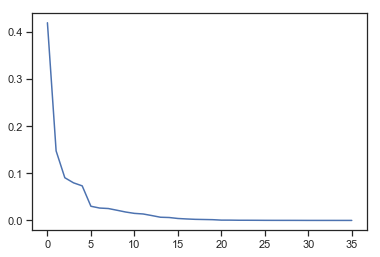

In [103]:
# Dimension reduction using PCA
pca = PCA(n_components=np.size(data[1]))
pca.fit(data)  
PCA(copy=True, iterated_power='auto', n_components=np.size(data[1]), random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
plt.plot(pca.explained_variance_ratio_) 
best_features_idx = [np.abs(pca.components_[i]).argmax() for i in range(30)]
n_components = np.sum((pca.explained_variance_ratio_.cumsum()/pca.explained_variance_ratio_.sum()) < 0.99)+1
print('The number of principal components necessary to recover 99% of variance:',n_components)
pca = PCA(n_components)
principal_pomponents = pca.fit_transform(data)

Feature ranking:
1. F2: Perimeter (0.140515)
2. F6: Compactness (0.139438)
3. F1: Cell Size (0.115384)
4. F31: Red Mean (0.032353)
5. F36: Value Mean (0.028767)
6. F3: Form Factor (0.028186)
7. F35: Saturation Mean (0.026764)
8. F34: Hue Mean (0.025768)
9. F32: Green Mean (0.025444)
10. F33: Blue Mean (0.022305)
11. F15: Haralick Sum Average (0.021937)
12. F23: Wavelet Approximation Mean (0.020786)
13. F5: Length/Diameter Ratio (0.018824)
14. F7: Boundary Roughness Variance (0.018676)
15. F4: Roundness (0.018170)
16. F30: Wavelet Diagonal Variance (0.017715)
17. F25: Wavelet Vertical Mean (0.016921)
18. F9: Boundary Roughness Kurtosis (0.016818)
19. F24: Wavelet Horizontal Mean (0.016044)
20. F19: Haralick Difference Variance (0.015803)
21. F26: Wavelet Diagonal Mean (0.015669)
22. F29: Wavelet Vertical Variance (0.015561)
23. F27: Wavelet Approximation Variance (0.015493)
24. F11: Haralick Contrast (0.015490)
25. F8: Boundary Roughness Skewness (0.015345)
26. F28: Wavelet Horizontal V

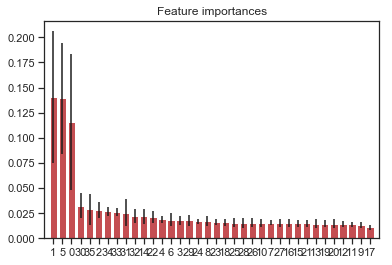

The number of components:  36


In [104]:
# Finding the most important features using Random Forest

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=10,
                              random_state=0)

Class = np.concatenate(([1]*len(ALL),[0]*len(hem)), axis=0) # labels: 1=ALL  0=hem
forest.fit(data, Class)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(data.shape[1]):
    print("%d. F%d: %s (%f)" % (f + 1, indices[f]+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

# Find the number of components
cum_importance = importances[indices].cumsum()/importances.sum()
n_components = np.sum(cum_importance < .99) + 1
print("The number of components: ", n_components)

In [105]:
# Conversion of data from numpy array to dataframe
data_df = pd.DataFrame.from_records(reduced_data)
data_df.columns = tuple('PC'+str(num+1) for num in range(np.size(reduced_data[1])))
Class = np.concatenate((['ALL']*len(ALL),['hem']*len(hem)), axis=0) 
data_df.insert(0,"Class",Class,True)
data_df

,Class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,ALL,-0.379634,-0.269456,0.374428,0.164329,-0.065750,-0.182896,0.044016,0.009811,-0.081168,0.066191,-0.054541,0.062772,0.010582,0.091639,-0.005604,-0.024795,-0.017724
1,ALL,-1.382895,-0.644953,-0.262077,-0.158259,0.303706,-0.298723,-0.033435,0.014169,0.074420,0.196456,-0.097846,0.196450,0.134809,0.026907,0.017247,0.166116,0.103227
2,ALL,-1.203195,-0.739906,0.026941,0.086058,0.174465,-0.388470,-0.026411,-0.078509,0.110819,-0.177492,-0.049450,0.234939,0.084329,-0.020694,0.149936,0.165330,0.073296
3,ALL,-1.203470,-0.817006,0.051207,-0.147455,0.248101,-0.309503,-0.120623,0.030742,-0.010785,-0.031148,-0.071351,0.021676,0.082867,0.053806,0.106336,0.086860,0.024395
4,ALL,-0.466806,-0.020585,0.471831,0.129147,0.148571,-0.001949,0.026445,0.080192,-0.084065,0.016056,-0.038101,0.001432,-0.013949,-0.008512,0.086408,0.013870,-0.021096
5,ALL,-1.753267,0.004661,0.133654,-0.201928,0.186385,-0.080279,0.066755,-0.016115,0.066970,-0.368132,0.007563,0.241138,-0.303091,-0.113180,-0.135615,0.094983,-0.237592
6,ALL,-1.223304,-0.061403,-0.121701,-0.322051,0.324936,-0.042295,0.126735,0.061829,0.110375,-0.040868,0.180929,0.120035,-0.079219,-0.032632,-0.143449,0.010330,-0.077066
7,ALL,-0.545633,0.433254,-0.000059,0.058790,-0.024849,-0.043375,-0.047597,-0.025615,0.015081,-0.249647,0.095940,0.091606,-0.115622,-0.066923,-0.002756,0.066854,0.005316
8,ALL,-1.138295,-0.499674,-0.121274,-0.039034,0.307842,-0.008942,0.028814,-0.097876,-0.096467,-0.012487,0.282004,0.072956,-0.081184,-0.075173,0.060816,0.134284,0.038226
9,ALL,-0.849026,0.258447,0.247571,0.141738,-0.034216,-0.069864,-0.143517,-0.047478,-0.017697,-0.197118,0.143511,0.085322,-0.092326,0.053183,-0.015422,0.064207,-0.011811


C:\Users\1000j\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


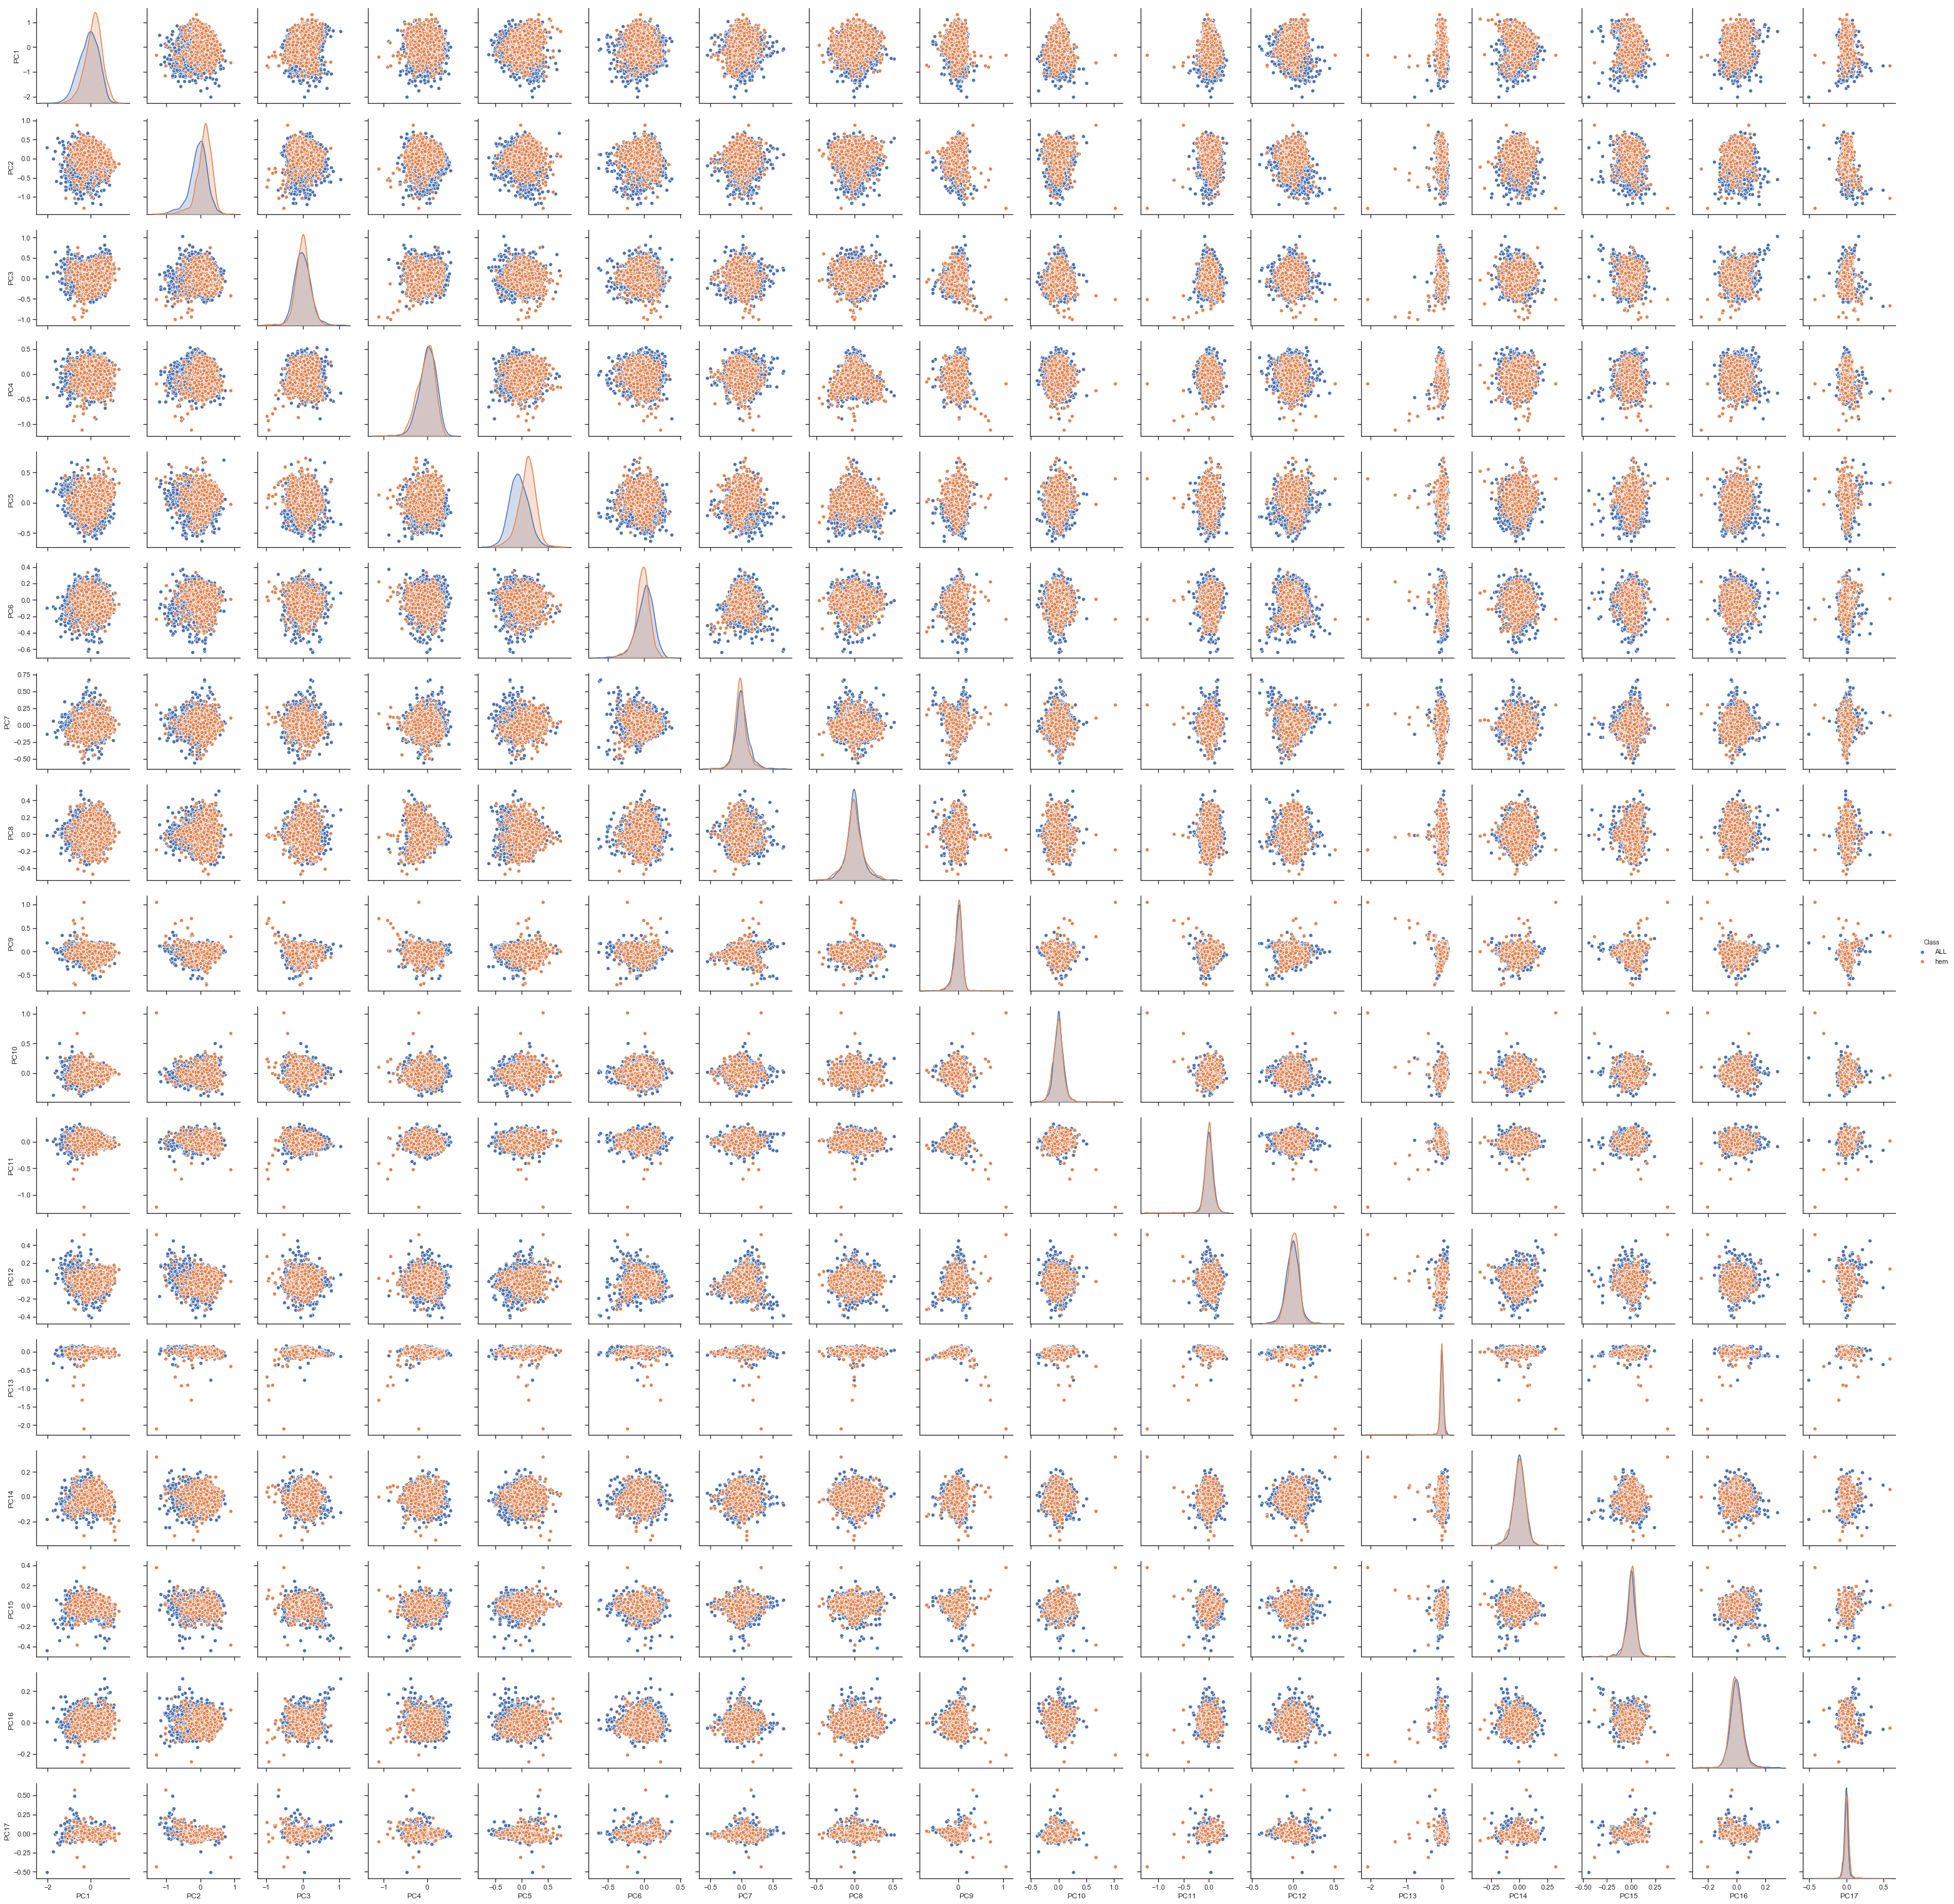

In [106]:
# Feature visualization
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data_df, hue="Class")

# Classification


In [ ]:
# Load test images


## Support Vector Machine (SVM)

In [107]:
#SVM
clf = svm.SVC(gamma='scale')
clf.fit(reduced_data, Class)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Model Evaluations